In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics import R2Score
import matplotlib.pyplot as plt

In [19]:
# 그래프 그려서 추세 맞는지 보기
stockDF = pd.read_csv('../../data/stock.csv')
stockDF.head()

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [20]:
stockDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


In [21]:
stockDF.Date = pd.to_datetime(stockDF.Date, format="%Y-%m-%d")

stockDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    967 non-null    datetime64[ns]
 1   Open    967 non-null    int64         
 2   High    967 non-null    int64         
 3   Low     967 non-null    int64         
 4   Volume  967 non-null    int64         
 5   Close   967 non-null    int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 45.5 KB


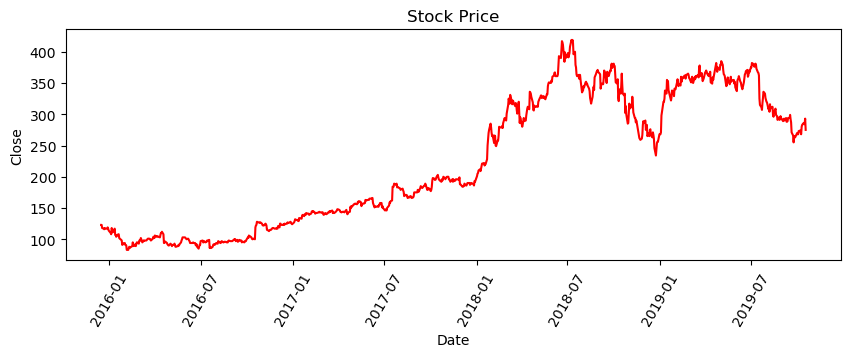

In [22]:
# 추세선 그래프 그리기
plt.figure(figsize=(10,3))
plt.plot(stockDF.Date, stockDF['Close'], color = 'red')
plt.title('Stock Price')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation = 60)
plt.show()

In [23]:
train_size = int(len(stockDF) * 0.8)
val_size = int(len(stockDF) * 0.1)

train = stockDF.iloc[:train_size]
val = stockDF.iloc[train_size:train_size+val_size]
test = stockDF.iloc[train_size+val_size:]

In [24]:
ytrain = train['Close']
xtrain = train.drop(['Close','Date','Volume'], axis=1)
ytest = test['Close']
xtest = test.drop(['Close','Date','Volume'], axis=1)
yval = val['Close']
xval = val.drop(['Close','Date','Volume'], axis=1)

In [25]:
class stock_dataset(Dataset):

    def __init__(self, data, label, window_size=30):
        data = data.values if isinstance(data, pd.DataFrame) else data
        label = label.values if isinstance(label, pd.Series) else label
        # 텐서화
        data_tensor = torch.FloatTensor(data)
        label_tensor = torch.FloatTensor(label)

        # 데이터 정규화
        self.data = data_tensor / torch.max(data_tensor)
        self.label = label_tensor / torch.max(label_tensor)

        self.window_size = window_size
        self.len = len(data) - window_size

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        index = index % len(self.data)  # 인덱스가 데이터셋의 길이를 벗어나면 다시 처음부터 시작
        data = self.data[index:index+self.window_size]  # 입력 데이터 30일치 읽기
        # 이전 한달 데이터를 가지고 하루의 종가 데이터 예측
        label = self.label[index+self.window_size]
        return data, label



In [26]:
trainDS = stock_dataset(xtrain, ytrain)
testDS = stock_dataset(xtest, ytest)
valDS = stock_dataset(xval, yval)

In [27]:
trainDL = DataLoader(trainDS, batch_size=12)
valDL = DataLoader(valDS, batch_size=12)

In [28]:
trainDS[0]

(tensor([[0.2837, 0.2908, 0.2790],
         [0.2931, 0.2979, 0.2884],
         [0.2861, 0.2884, 0.2790],
         [0.2837, 0.2837, 0.2742],
         [0.2766, 0.2766, 0.2719],
         [0.2766, 0.2813, 0.2742],
         [0.2790, 0.2813, 0.2766],
         [0.2766, 0.2766, 0.2695],
         [0.2790, 0.2837, 0.2766],
         [0.2813, 0.2813, 0.2742],
         [0.2742, 0.2766, 0.2695],
         [0.2577, 0.2600, 0.2482],
         [0.2600, 0.2624, 0.2506],
         [0.2482, 0.2790, 0.2482],
         [0.2742, 0.2884, 0.2648],
         [0.2742, 0.2790, 0.2624],
         [0.2648, 0.2766, 0.2624],
         [0.2742, 0.2790, 0.2719],
         [0.2695, 0.2695, 0.2482],
         [0.2506, 0.2577, 0.2388],
         [0.2411, 0.2506, 0.2411],
         [0.2530, 0.2600, 0.2506],
         [0.2577, 0.2600, 0.2293],
         [0.2553, 0.2577, 0.2411],
         [0.2482, 0.2482, 0.2340],
         [0.2364, 0.2435, 0.2340],
         [0.2364, 0.2388, 0.2246],
         [0.2293, 0.2317, 0.2151],
         [0.2222, 0.

In [53]:
class StockModel(nn.Module):
    def __init__(self, ):
        super(StockModel, self).__init__()
        self.rnn = nn.LSTM(3, 8, 5, batch_first=True)
        self.fc1 = nn.Linear(8 * 30, 64)  # 수정된 입력 크기
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()


    def forward(self, x):
        # LSTM 층의 출력
        output, _ = self.rnn(x)

        # LSTM 층의 마지막 타임 스텝의 출력만 사용
        output = output[:, -1, :]

        # fc층 입력을 위해 평탄화
        output = torch.flatten(output, start_dim=1)

        # 첫 번째 fully connected layer 적용
        output = self.fc1(output)
        output = self.relu(output)

        # 두 번째 fully connected layer 적용
        output = self.fc2(output)
        
        return output


In [58]:
class StockModel(nn.Module):
    def __init__(self): 
        super(StockModel, self).__init__()
        self.hidden_size=8
        self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5, batch_first=True)
        self.fc = nn.Linear(240, 64)
        self.fc2 = nn.Linear(64, 1)
    def forward(self, x):
        h0 = torch.zeros(5, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = out.contiguous().view(out.size(0), -1)
        out = self.fc(out)
        out = self.fc2(out)
        return out

In [59]:
IN = xtrain.shape[1]
OUT = 1
model = StockModel()
OPTIMIZER = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 300
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 3)
r2score = R2Score()

In [60]:
def training(dl):
    loss_list = []
    r2_list = []
    model.train()
    for x, y in dl:
        y_pred = model(x)
        loss =  F.l1_loss(y_pred, y.unsqueeze(1))
        r2 = r2score(y_pred,y.unsqueeze(1))
        OPTIMIZER.zero_grad()
        loss.backward()
        OPTIMIZER.step()
        loss_list.append(loss.item())
        r2_list.append(r2.item())
    train_loss = np.mean(loss_list)
    train_r2 = np.mean(r2_list)
    return train_loss, train_r2

In [61]:
def testing(dl):
    loss_list = []
    r2_list = []
    model.eval()
    with torch.no_grad():
        for x, y in dl:
            y_pred = model(x)
            loss =  F.l1_loss(y_pred, y.unsqueeze(1))
            r2 = r2score(y_pred,y.unsqueeze(1))
            loss_list.append(loss.item())
            r2_list.append(r2.item())

    val_loss = np.mean(loss_list)
    val_r2 = np.mean(r2_list)
    return val_loss, val_r2

In [62]:
min_loss = np.inf
for epoch in range(EPOCHS):
    train_loss, train_r2 = training(trainDL)
    val_loss, val_r2 = testing(valDL)
    print(f'[Epoch : {epoch+1} / {EPOCHS}]')
    print(f'Train Loss : {train_loss:.4f} Train R2 : {train_r2:.4f}')
    print(f'Test Loss : {val_loss:.4f} Test R2 : {val_r2:.4f}')
    SCHEDULER.step(val_loss)
    if min_loss > val_loss:
        min_loss = val_loss
        torch.save(model, 'boston_model.pt')
    if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
        print(f'조기 종료 at epoch {epoch}')
        break

[Epoch : 1 / 300]
Train Loss : 0.0520 Train R2 : -43.4733
Test Loss : 0.3741 Test R2 : -714.2342
[Epoch : 2 / 300]
Train Loss : 0.0814 Train R2 : -175.3344
Test Loss : 0.3588 Test R2 : -656.2568
[Epoch : 3 / 300]
Train Loss : 0.1130 Train R2 : -241.2339
Test Loss : 0.2305 Test R2 : -266.3322
[Epoch : 4 / 300]
Train Loss : 0.0984 Train R2 : -408.4277
Test Loss : 0.3762 Test R2 : -722.8853
[Epoch : 5 / 300]
Train Loss : 0.1098 Train R2 : -248.7288
Test Loss : 0.1988 Test R2 : -196.7133
[Epoch : 6 / 300]
Train Loss : 0.1486 Train R2 : -666.5975
Test Loss : 0.2822 Test R2 : -402.7647
[Epoch : 7 / 300]
Train Loss : 0.1126 Train R2 : -458.6065
Test Loss : 0.3640 Test R2 : -675.6859
[Epoch : 8 / 300]
Train Loss : 0.1084 Train R2 : -367.1443
Test Loss : 0.3769 Test R2 : -725.3149
조기 종료 at epoch 7


In [ ]:
testDS.data.ndim, testDS.data.shape

(2, torch.Size([98, 4]))

In [ ]:
# def prediction(ds):
#     model.eval()
#     with torch.no_grad():
#         pre = model(ds.data)
#         loss =  F.l1_loss(pre, ds.label)
#         print(f'Test Loss : {loss.item():.4f}')

# prediction(testDS)